In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split  

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import itertools

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
def finam_load(filename, candles_):
    
    df = pd.read_csv(filename, sep=',')
    df.columns = [str(x)[1:-1] for x in df.columns]
    df['TIME'] = df['TIME'].apply(lambda x: '0'+str(x) if len(str(x)) < 6 else x)
    df.DATE = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str),
                             format='%Y%m%d %H:%M:%S')
    df = df[['DATE', candles_]].rename(columns={'DATE': 'ds',
                                               candles_: filename.split('_')[0]
                                              })
    return df

In [4]:
sber = finam_load('SBER_190101_200101.txt', candles_='CLOSE')

usd_rur = finam_load('USDRUB_190101_200101.txt', candles_='CLOSE')

df = sber.merge(usd_rur, on='ds', how='left')

df = df.rename(columns={'SBER': 'y'})

df['monthday'] = df.ds.dt.day
df['weekday'] = df.ds.dt.weekday

In [5]:
div_date = '2019-10-01'

df = df[df.ds.dt.hour == 18]

train, test = df[df.ds < div_date], df[df.ds >= div_date]

In [6]:

def shift_columns(data, column_lst, shifting_periods_lst=[7], drop=False):

    for column in column_lst:
        for period_ in shifting_periods_lst:
            sft_col = column + '_shift_{}'.format(period_)
            data[sft_col] = data[column].shift(period_)

    if drop:
        data = data.dropna()

    return data


df = shift_columns(df, ['USDRUB'], [7, 14], True)

In [8]:
from alm_lstm import DataLoader, LSTM_ts

In [60]:
DL = DataLoader(df, 
                categorical_features_names=['monthday', 'weekday'], 
                continuous_features_names=[x for x in df.columns if 'USDRUB' in x],
                target_name='y', 
                seq_lenght=5)

In [61]:
DL.data.head()

,ds,y,USDRUB,monthday,weekday,USDRUB_shift_7,USDRUB_shift_14
133,2019-01-24 18:00:00,211.94,65.8720,24,3,67.0918,68.9979
142,2019-01-25 18:00:00,212.85,66.1517,25,4,66.7800,67.9258
151,2019-01-28 18:00:00,208.54,65.9750,28,0,66.4376,66.9450
160,2019-01-29 18:00:00,212.94,66.2356,29,1,66.2998,67.0045
169,2019-01-30 18:00:00,213.33,65.9444,30,2,66.4350,67.0392


In [62]:
cat_feat_scale_sequence, cont_feat_scale_sequence, y_scale_sequence = DL.transform()

In [63]:
batch_size = df.shape[0]
test_size = int(0.2 * batch_size)

x = Variable(torch.cat([cont_feat_scale_sequence, cat_feat_scale_sequence], axis=2))
X_train = x[:batch_size - test_size]
X_test = x[batch_size - test_size: batch_size]

y_train = y_scale_sequence[:batch_size - test_size]
y_test = y_scale_sequence[batch_size - test_size: batch_size]


cat_feat_train = cat_feat_scale_sequence[:batch_size - test_size]
cont_feat_train = cont_feat_scale_sequence[:batch_size - test_size]

cat_feat_test = cat_feat_scale_sequence[batch_size - test_size: batch_size]
cont_feat_test = cont_feat_scale_sequence[batch_size - test_size: batch_size]

In [69]:
torch.manual_seed(13)

#nn.LSTM parameters
input_size = cont_feat_scale_sequence.shape[2] + cat_feat_scale_sequence.shape[2] 
hidden_size = 30
num_layers = 3
dropout = 0.2

#LSTM_ts parameters
seq_lenght = 5
output_size = 1
embed_dropout = 0.4

model = LSTM_ts(seq_lenght=seq_lenght,
                output_size=output_size, 
                embed_dropout=embed_dropout,
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout = dropout)
model

LSTM_ts(
  (embed_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(22, 30, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [70]:
epochs = 201

loss_func= nn.MSELoss()       ## Convert into RMSE later
optimizer= torch.optim.Adam(model.parameters(), lr=0.01)

Epoch number: 200 and the Loss: 0.045754995197057724


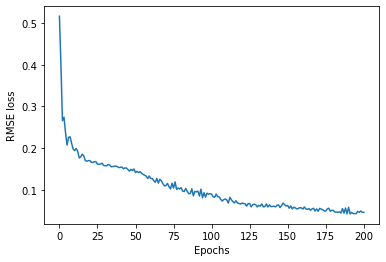

In [71]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

model.train() #!!!!

final_losses = []
for i in range(epochs):

    y_pred = model(cont_feat_train, cat_feat_train)
    loss = torch.sqrt(loss_func(y_pred, y_train))     ## RMSE
    
    final_losses.append(loss)
    if i % 50 == 0:
        
        clear_output()
        print("Epoch number: {} and the Loss: {}".format(i, loss.item()))
        plt.plot(range(i + 1), final_losses)
        plt.ylabel('RMSE loss')
        plt.xlabel('Epochs')
        plt.show()        

        
    optimizer.zero_grad()
    loss.backward()         ##back propogation
    optimizer.step()

In [72]:
model.eval()
train_predict = model(X_test)

data_predict = train_predict.data.numpy()
dataY_plot = y_test.data.numpy()

data_predict = DL.get_Scaler().inverse_transform(data_predict)
dataY_plot = DL.get_Scaler().inverse_transform(dataY_plot)

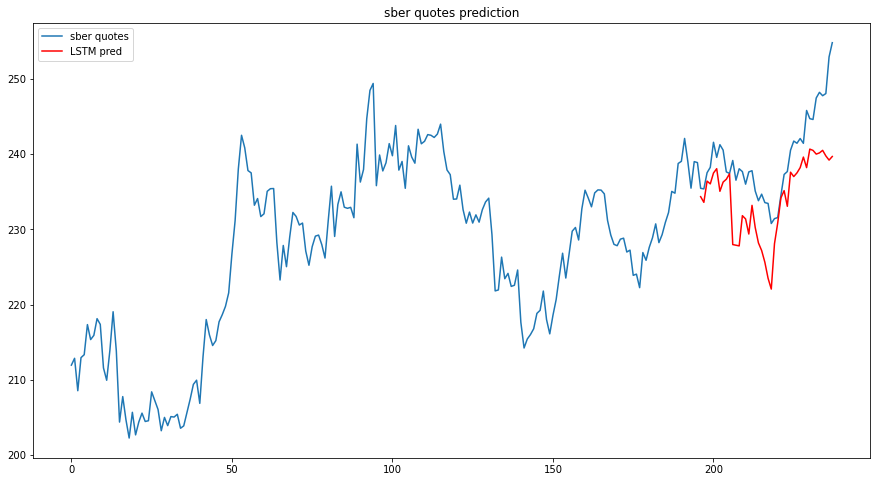

In [79]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(df.y.reset_index(drop=True), label='sber quotes')

ax.plot(np.arange(batch_size - test_size + seq_lenght, batch_size), 
        data_predict[:, 0], label='LSTM pred', color='r')  #simple prophet model


ax.set_title('sber quotes prediction')

plt.legend()

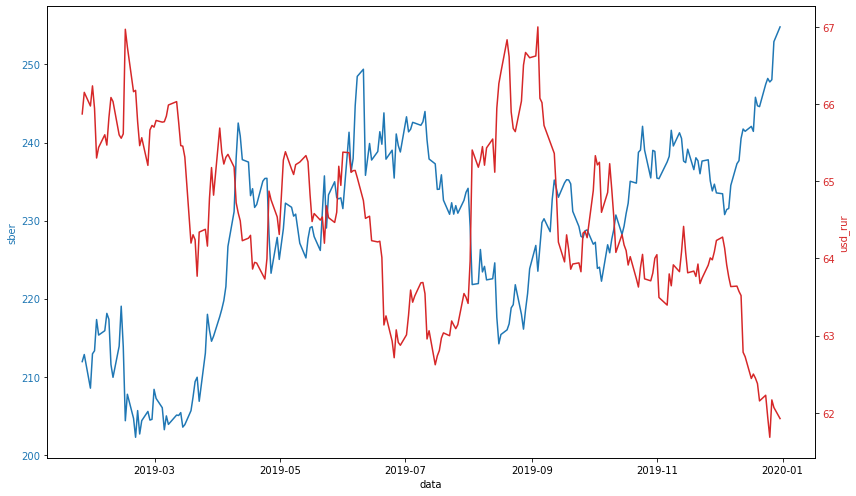

In [80]:
fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('data')
ax1.set_ylabel('sber', color=color)
ax1.plot(df.ds, df.y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('usd_rur', color=color) 
ax2.plot(df.ds, df.USDRUB, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()
